#Importing data from Kaggle to Google Colab

In [3]:
!pip install kaggle


In [4]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mohamedzanaty","key":"4206f7e6d57adb89a17f480bd26c36e2"}'}

In [5]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d nipunarora8/age-gender-and-ethnicity-face-data-csv

 93% 59.0M/63.2M [00:00<00:00, 58.7MB/s]
100% 63.2M/63.2M [00:00<00:00, 72.2MB/s]


In [7]:
!unzip age-gender-and-ethnicity-face-data-csv.zip

Archive:  age-gender-and-ethnicity-face-data-csv.zip
  inflating: age_gender.csv          


#Importing what we need

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, experimental, MaxPool2D, BatchNormalization
from tensorflow.keras.losses import sparse_categorical_crossentropy, binary_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau 
from tensorflow.data import Dataset
from tensorflow.keras import Input, Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.random import set_seed
from tensorflow.keras.utils import to_categorical
from tensorflow import test
import random
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from  IPython.display import display
import plotly.express as px


#Reading data

In [2]:
data=pd.read_csv("/content/age_gender.csv")
data.info

<bound method DataFrame.info of        age  ...                                             pixels
0        1  ...  129 128 128 126 127 130 133 135 139 142 145 14...
1        1  ...  164 74 111 168 169 171 175 182 184 188 193 199...
2        1  ...  67 70 71 70 69 67 70 79 90 103 116 132 145 155...
3        1  ...  193 197 198 200 199 200 202 203 204 205 208 21...
4        1  ...  202 205 209 210 209 209 210 211 212 214 218 21...
...    ...  ...                                                ...
23700   99  ...  127 100 94 81 77 77 74 99 102 98 128 145 160 1...
23701   99  ...  23 28 32 35 42 47 68 85 98 103 113 117 130 129...
23702   99  ...  59 50 37 40 34 19 30 101 156 170 177 184 187 1...
23703   99  ...  45 108 120 156 206 197 140 180 191 199 204 207...
23704   99  ...  156 161 160 165 170 173 166 177 183 191 187 18...

[23705 rows x 5 columns]>

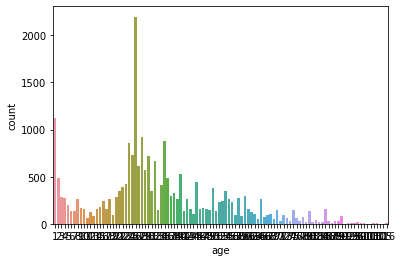

In [3]:
sns.countplot(x='age', data=data)

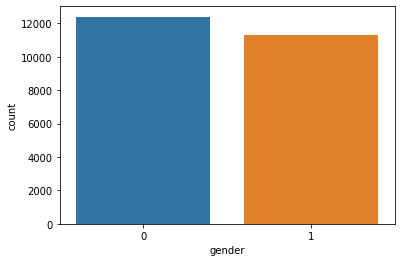

In [4]:
sns.countplot(x='gender', data=data)

#Specifying only persons who has age more than 18 

,age,ethnicity,gender,img_name,pixels
0,100,0,0,20170112213500903.jpg.chip.jpg,203 185 139 163 176 184 186 175 175 156 159 13...
1,100,0,0,20170112215240346.jpg.chip.jpg,125 126 115 78 66 66 77 85 95 102 117 138 138 ...
2,100,0,1,20170110183726390.jpg.chip.jpg,235 164 113 144 121 201 243 237 234 221 233 23...
3,100,0,1,20170112213001988.jpg.chip.jpg,82 82 82 82 82 82 84 86 90 85 104 105 102 154 ...
4,100,0,1,20170112213303693.jpg.chip.jpg,70 72 94 149 154 166 175 169 172 161 176 187 2...
...,...,...,...,...,...
19467,99,0,1,20170120221920654.jpg.chip.jpg,127 100 94 81 77 77 74 99 102 98 128 145 160 1...
19468,99,1,1,20170120134639935.jpg.chip.jpg,23 28 32 35 42 47 68 85 98 103 113 117 130 129...
19469,99,2,1,20170110182418864.jpg.chip.jpg,59 50 37 40 34 19 30 101 156 170 177 184 187 1...
19470,99,2,1,20170117195405372.jpg.chip.jpg,45 108 120 156 206 197 140 180 191 199 204 207...


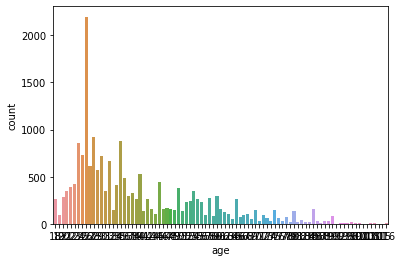

In [5]:
data = data[data['age'] >= 18]
sns.countplot(x='age', data=data)
data.reset_index(drop=True, inplace=True)
data

#Checking null values

In [6]:
data.isnull().sum()

age          0
ethnicity    0
gender       0
img_name     0
pixels       0
dtype: int64

#Image configuration

In [7]:
# Input image configuration
num_pixels = len(data['pixels'][0].split(' '))
dimension = int(np.sqrt(num_pixels))
img_width = dimension
img_height = dimension

In [8]:
print("Pixels: {}".format(num_pixels))
print("Width: {0}, Height: {1}".format(img_width, img_height))

Pixels: 2304
Width: 48, Height: 48


#Dataset splitting

In [9]:
X_img = data.iloc[:,4].copy()
y_age = data.iloc[:,0].copy()
y_ethnicity = data.iloc[:,1].copy()
y_gender = data.iloc[:,2].copy()

#splitting into training and testing.
X_train, X_te, y_train, y_te = train_test_split(X_img,y_gender,test_size=0.3,random_state=11)
#splitting testing into validation and tests
X_val, X_test, y_val, y_test = train_test_split(X_te,y_te,test_size=0.15,random_state=11)

#Function to convert pixel data (string) into numpy_array of pixels

In [10]:
def str_to_npArr(x):
    x = x.reset_index(drop=True)
    x = x.apply(lambda x: np.array(x.split(), dtype="float32")) #converting data to numpy array
    return np.array([x[i].reshape(img_width, img_height, 1) for i in range(x.shape[0])])

#Converting the string of pixels into image array for each of train, val and test set and normalization


In [11]:
X_train = str_to_npArr(X_train)
X_test = str_to_npArr(X_test)
X_val = str_to_npArr(X_val)

In [12]:
print("Traget: shape = (16593, 48, 48, 1), type = <class 'numpy.ndarray'>")
print("Current: shape = {}, type = {}".format(X_train.shape, type(X_train)))

Traget: shape = (16593, 48, 48, 1), type = <class 'numpy.ndarray'>
Current: shape = (13630, 48, 48, 1), type = <class 'numpy.ndarray'>


In [13]:
target_columns = ['gender', 'ethnicity', 'age']
data_preprocess = data.drop('img_name', axis=1)
y = data_preprocess[target_columns]
X = data_preprocess.drop(target_columns, axis=1)

print(X)
print("--------------------------------------------------------")
print(y)

                                                  pixels
0      203 185 139 163 176 184 186 175 175 156 159 13...
1      125 126 115 78 66 66 77 85 95 102 117 138 138 ...
2      235 164 113 144 121 201 243 237 234 221 233 23...
3      82 82 82 82 82 82 84 86 90 85 104 105 102 154 ...
4      70 72 94 149 154 166 175 169 172 161 176 187 2...
...                                                  ...
19467  127 100 94 81 77 77 74 99 102 98 128 145 160 1...
19468  23 28 32 35 42 47 68 85 98 103 113 117 130 129...
19469  59 50 37 40 34 19 30 101 156 170 177 184 187 1...
19470  45 108 120 156 206 197 140 180 191 199 204 207...
19471  156 161 160 165 170 173 166 177 183 191 187 18...

[19472 rows x 1 columns]
--------------------------------------------------------
       gender  ethnicity  age
0           0          0  100
1           0          0  100
2           1          0  100
3           1          0  100
4           1          0  100
...       ...        ...  ...
19467       1          

In [14]:
X = X['pixels'].apply(lambda x: np.array(x.split(), dtype="float32")) #converting data to numpy array
X = np.array(X)/255.0 # normalization
X = np.array([ X[i].reshape(48,48,1) for i in range(X.shape[0]) ])

print("Traget: X Shape: {}".format(X.shape))
print("Current: X Shape: {}".format(X.shape))

Traget: X Shape: (19472, 48, 48, 1)
Current: X Shape: (19472, 48, 48, 1)


In [15]:
y_gender = np.array(y['gender'])
y_ethnicity = np.array(y['ethnicity'])
y_age = np.array(y['age'])

#Let's show some samples

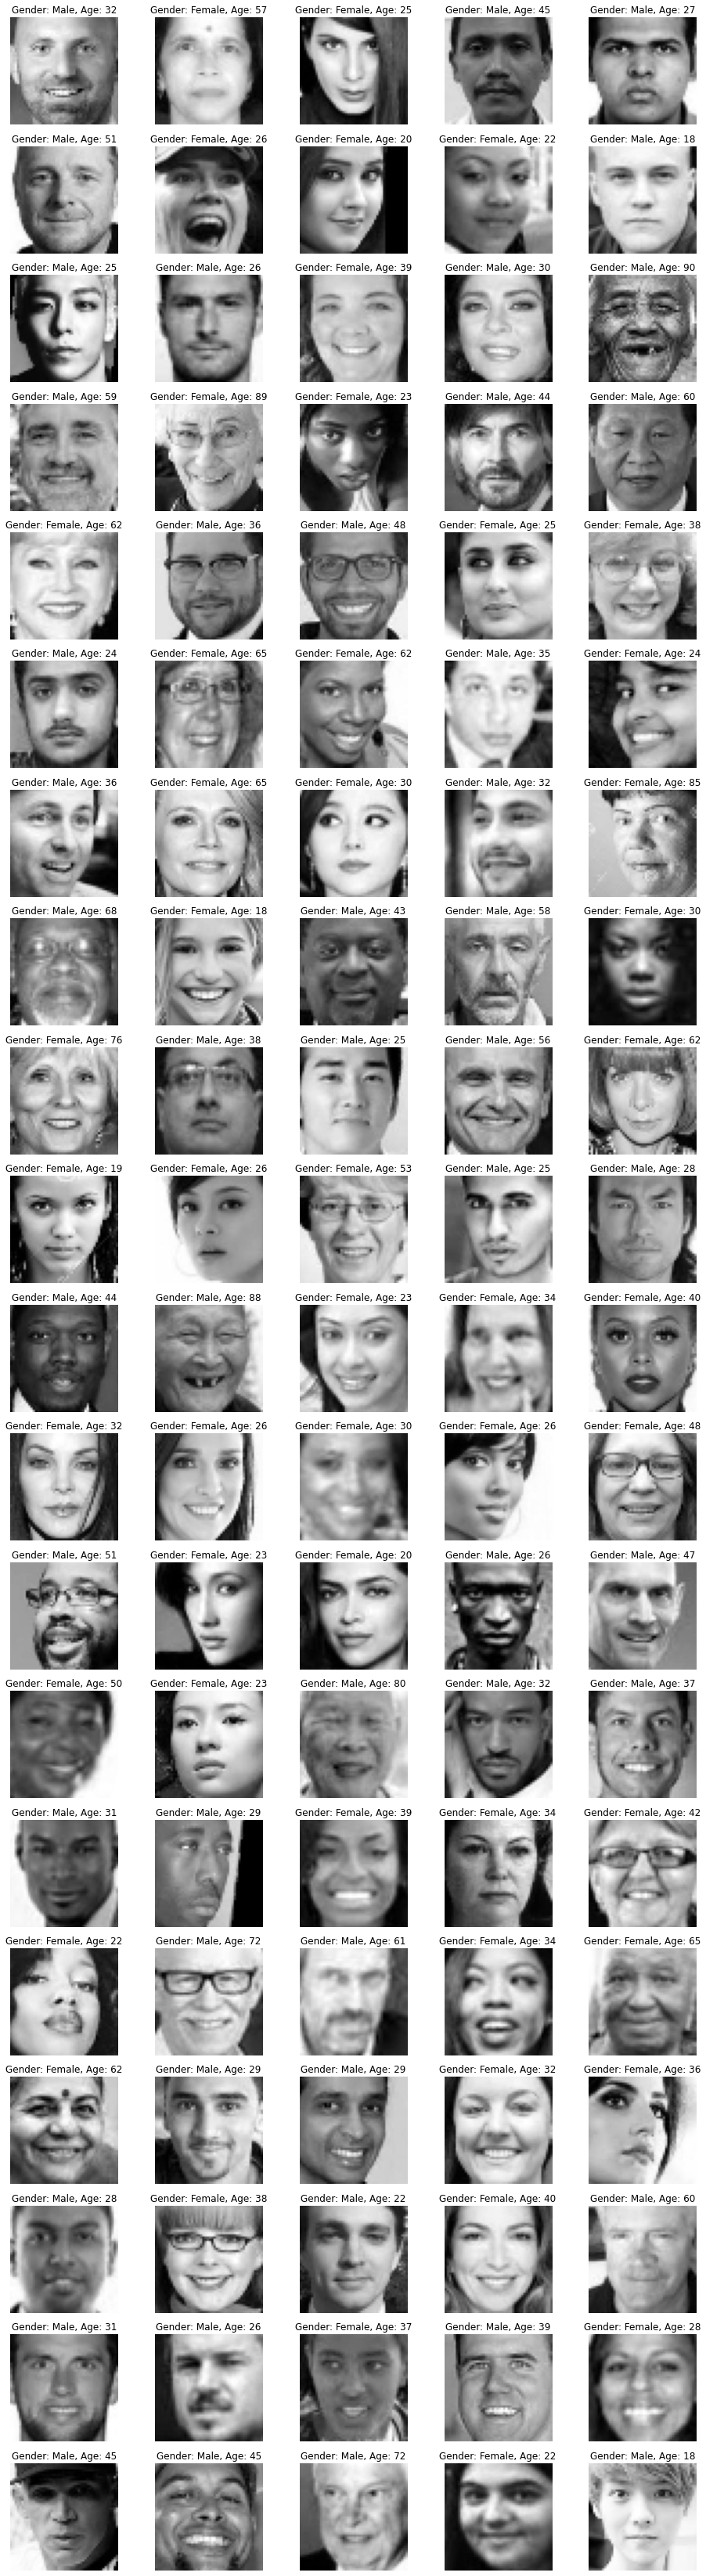

In [16]:
rows = 20
cols = 5
samp = random.sample(range(X.shape[0]),rows*cols)
x_samp = X[samp,:,:,:]
y_samp_gender = y_gender[samp]
y_samp_age = y_age[samp]
fig,ax = plt.subplots(rows,cols,figsize=(16,60))
r = 0
c = 0   
for i in range(rows*cols):
    aa = x_samp[i,:,:,:].reshape(48,48)
    ax[r,c].axis("off")
    ax[r,c].imshow(aa,cmap="gray")
    ax[r,c].set_title(f"Gender: {'Female' if y_samp_gender[i]==1 else 'Male'}, Age: {y_samp_age[i]}")
    c+=1
    if c == cols:
        c=0
        r+=1
        
plt.show()

#Data augmentation
We use data augmentation to increase the amount of available training models without actually collecting. Techniques used are cropping, padding, and horizontal flipping. These techniques are also used to train large neural networks.


In [17]:
train_data_gen = ImageDataGenerator(rotation_range=30,
                                   width_shift_range=1,
                                    brightness_range=[0.8,1.2],
                                    zoom_range=[0.8,1.2],
                                    rescale=1/255
                                   )
val_data_gen = ImageDataGenerator(rescale=1/255)

test_data_gen = ImageDataGenerator(rescale=1/255)

In [18]:
set_seed(11)
random.seed(11)
np.random.seed(11)

val_data = val_data_gen.flow(X_val,y_val,
                                   seed=11,shuffle=False)

test_data = test_data_gen.flow(X_test,y_test,
                                   seed=11,shuffle=False)

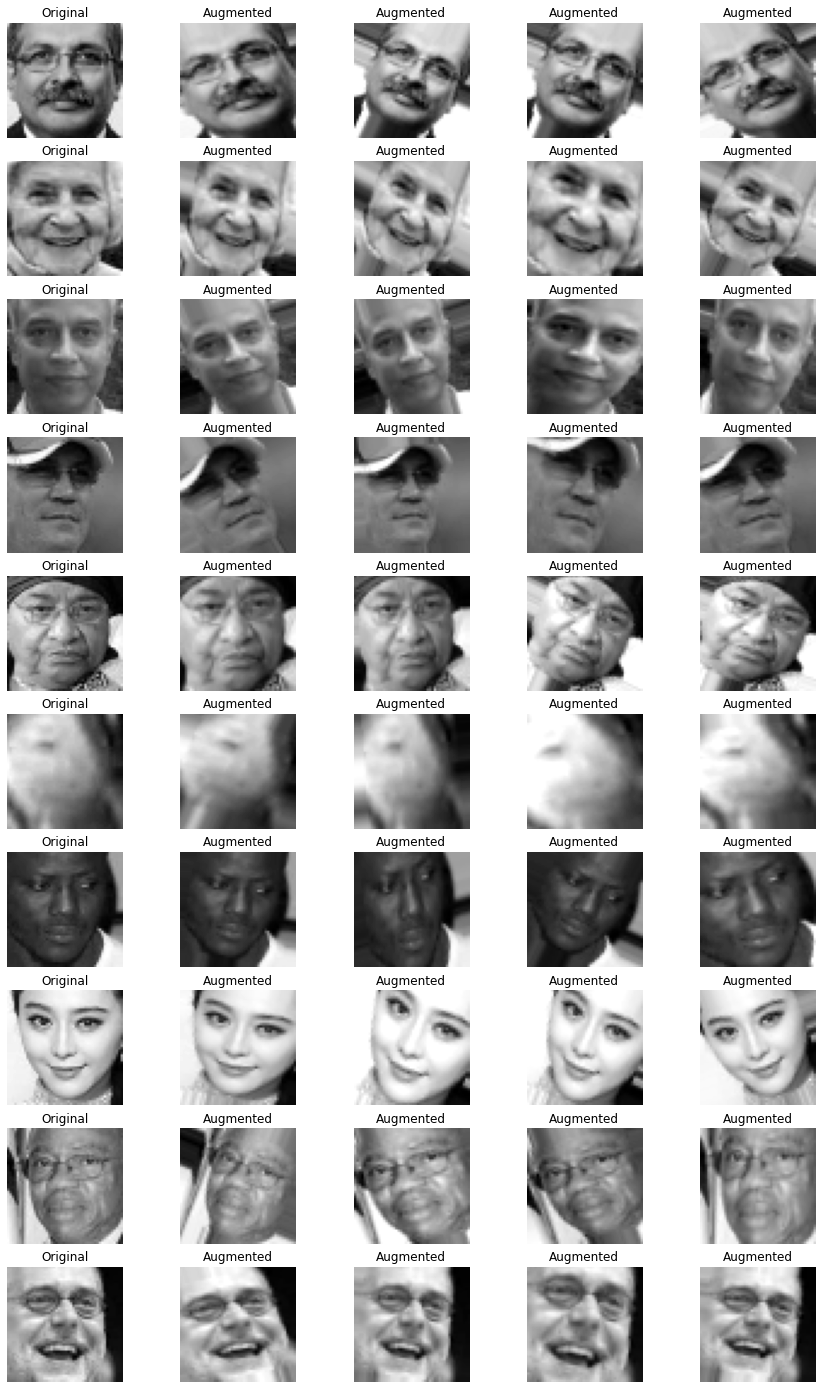

In [19]:
fig,ax = plt.subplots(10,5,figsize=(15,25))
for n in range(10):    
    r = random.sample(range(X.shape[0]),1)[0]
    ax[n,0].imshow(X[r].reshape(48,48),cmap="gray")
    ax[n,0].set_title("Original")
    ax[n,0].axis("off")
    for i in range(1,5):
        ax[n,i].imshow(train_data_gen.random_transform(X[r]).reshape(48,48),cmap="gray")
        ax[n,i].set_title("Augmented")
        ax[n,i].axis("off")
plt.show()

#Training Model

In [22]:
#configuration
batch_size = 32
img_width, img_height, img_num_channels = 48, 48, 1
loss_function = sparse_categorical_crossentropy
no_classes = 2
no_epochs = 7
optimizer = Adam()
verbosity = 1
num_folds = 2
activation='softmax'

# Determine shape of the data
input_shape = (img_width, img_height, img_num_channels)
input_shape

(48, 48, 1)

In [23]:
# Set Seed
random.seed(11)
set_seed(11)
np.random.seed(11)

# Define the K-fold Cross Validator
kfold = KFold(n_splits=num_folds, shuffle=True)

# Define per-fold score containers
acc_per_fold = []
loss_per_fold = []

# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(X, y_gender):
    
  # Set Seed
  random.seed(11)
  set_seed(11)
  np.random.seed(11)
  
  # Define the model architecture
  model = Sequential()
  
  model.add(Conv2D(64, kernel_size=(3,3), input_shape=input_shape, activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(BatchNormalization())

  model.add(Conv2D(128, kernel_size=(3,3), activation='relu', padding='same'))
  model.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.3))
  model.add(BatchNormalization())

  model.add(Conv2D(256, kernel_size=(3,3), activation='relu', padding='same'))
  model.add(Conv2D(256, kernel_size=(3,3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.3))
  model.add(BatchNormalization())

  model.add(Conv2D(512, kernel_size=(3,3), activation='relu', padding='same'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.5))
  model.add(BatchNormalization())

  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dense(128, activation='softmax'))

  # Compile the model
  model.compile(loss=loss_function,
              optimizer=optimizer,
              metrics=['accuracy'])
  
  # Generate a print
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')
    
  early_stop = EarlyStopping(monitor="val_loss",patience=5,mode="min") # Ensure the model doesn't overfit
  
  # Set Seed
  random.seed(11)
  set_seed(11)
  np.random.seed(11)
    
  # Fit data to model
  history = model.fit(train_data_gen.flow(X[train], y_gender[train], seed=11),
            callbacks=early_stop,
            batch_size=batch_size,
            epochs=no_epochs,
            verbose=verbosity,
            validation_data=train_data_gen.flow(X[test], y_gender[test],
                                   seed=11))
  
  # Generate generalization metrics
  fig = px.line(
  history.history, y=['loss', 'val_loss'],
  labels={'index': 'epoch', 'value': 'loss'}, 
  title='Training History')
  fig.show()
    
  scores = model.evaluate(train_data_gen.flow(X[test], y_gender[test],
                                   seed=11), verbose=0)
  print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
  acc_per_fold.append(scores[1] * 100)
  loss_per_fold.append(scores[0])
  
  # Increase fold number
  fold_no = fold_no + 1

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/7
305/305 [==============================] - 365s 1s/step - loss: 1.1397 - accuracy: 0.6382 - val_loss: 1.0576 - val_accuracy: 0.5318
Epoch 2/7
305/305 [==============================] - 358s 1s/step - loss: 0.3873 - accuracy: 0.8294 - val_loss: 0.8507 - val_accuracy: 0.6734
Epoch 3/7
305/305 [==============================] - 360s 1s/step - loss: 0.3166 - accuracy: 0.8684 - val_loss: 0.3934 - val_accuracy: 0.8220
Epoch 4/7
305/305 [==============================] - 360s 1s/step - loss: 0.2995 - accuracy: 0.8778 - val_loss: 0.2826 - val_accuracy: 0.8841
Epoch 5/7
305/305 [==============================] - 362s 1s/step - loss: 0.2636 - accuracy: 0.8918 - val_loss: 0.3063 - val_accuracy: 0.8679
Epoch 6/7
305/305 [==============================] - 356s 1s/step - loss: 0.2490 - accuracy: 0.9016 - val_loss: 0.3156 - val_accuracy: 0.8813
Epoch 7/7
305/305 [==============================] 

Score for fold 1: loss of 0.24517811834812164; accuracy of 90.3656542301178%
------------------------------------------------------------------------
Training for fold 2 ...
Epoch 1/7
305/305 [==============================] - 356s 1s/step - loss: 1.0474 - accuracy: 0.6302 - val_loss: 1.2164 - val_accuracy: 0.5343
Epoch 2/7
305/305 [==============================] - 355s 1s/step - loss: 0.4669 - accuracy: 0.7886 - val_loss: 0.4852 - val_accuracy: 0.7773
Epoch 3/7
305/305 [==============================] - 356s 1s/step - loss: 0.3716 - accuracy: 0.8410 - val_loss: 0.5724 - val_accuracy: 0.6945
Epoch 4/7
305/305 [==============================] - 358s 1s/step - loss: 0.3480 - accuracy: 0.8533 - val_loss: 0.3176 - val_accuracy: 0.8682
Epoch 5/7
305/305 [==============================] - 362s 1s/step - loss: 0.3211 - accuracy: 0.8683 - val_loss: 0.2966 - val_accuracy: 0.8758
Epoch 6/7
305/305 [==============================] - 358s 1s/step - loss: 0.3110 - accuracy: 0.8701 - val_loss: 0.26

Score for fold 2: loss of 0.267926961183548; accuracy of 89.32826519012451%


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning:

`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).



              precision    recall  f1-score   support

           0       0.91      0.95      0.93       468
           1       0.94      0.89      0.92       409

    accuracy                           0.92       877
   macro avg       0.93      0.92      0.92       877
weighted avg       0.93      0.92      0.92       877



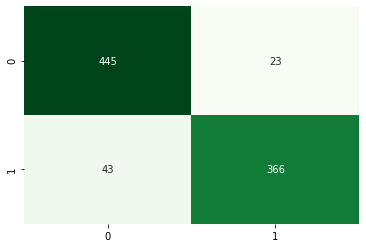

In [26]:
y_pred = model.predict_classes(test_data)
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, cmap='Greens', cbar=False, annot=True, fmt='d');